# CNN + MaxPool
Same as CNN_264 which achieved about 60% accuracy on all cell lines except H1.hESC. 

Here, run the same model on cell line GM12878 only. 

In [13]:
from datetime import datetime
print(datetime.now())

2023-03-26 18:29:55.931438


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = {x for x in range(NUM_CELL_LINES) if x!=12}   # exclude all but H1.hESC
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14}


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [19]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 18:29:56.950221
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_22 (Conv1D)          (None, 4990, 64)          2112      
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 1246, 64)         0         
 g1D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 1246, 64)          0         
                                                                 
 conv1d_23 (Conv1D)          (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 308, 64)          0         
 g1D)                     

## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 18:29:57.167039
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 1931
Num RCI: 1931
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 1931 sequences.
2023-03-26 18:29:59.834173

Training # 1 1
2023-03-26 18:29:59.834325
2023-03-26 18:29:59.834368
Discriminator ZERO -1
Train 1:0 753:821 47.84%
Computed class weights: {0: 0.9585870889159561, 1: 1.045152722443559}
Valid 1:0 185:172 51.82%
FIT
2023-03-26 18:30:00.445040


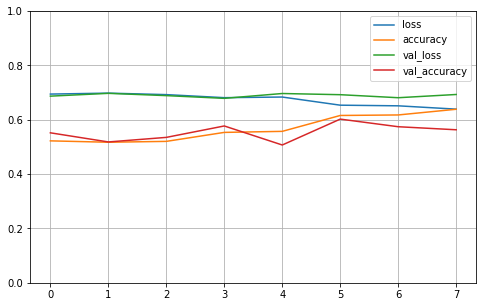


2023-03-26 18:30:08.421506

Testing # 1 1
2023-03-26 18:30:08.425954
2023-03-26 18:30:08.426426
PREDICT
2023-03-26 18:30:08.518873
Test 1:0 185:172 51.82%
Predict 1:0 97:260 27.17%
Test sizes (357, 4997) (357,)
Range of scores: 0.093408786 to 0.89982444
Score threshold 0.5
Confusion matrix
 [[138  34]
 [122  63]]
Normalized matrix
 [[0.38655462 0.0952381 ]
 [0.34173669 0.17647059]]


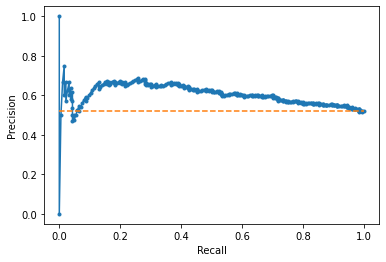

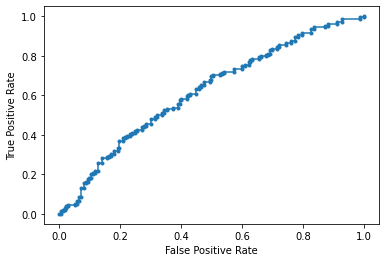

Accuracy: 56.30% Precision: 64.95% Recall: 34.05%
F1: 44.68% MCC: 0.1605
AUPRC: 60.38% AUROC: 61.93%
 accuracy [56.30252100840336]
 precision [64.94845360824742]
 recall [34.054054054054056]
 F1 [44.68085106382979]
 MCC [0.16047478504250773]
 AUPRC [60.378024230077564]
 AUROC [61.929604022627274]
2023-03-26 18:30:09.028965

Training # 1 2
2023-03-26 18:30:09.029105
2023-03-26 18:30:09.029147
Discriminator ZERO -1
Train 1:0 749:772 49.24%
Computed class weights: {0: 0.9851036269430051, 1: 1.0153538050734312}
Valid 1:0 189:221 46.10%
FIT
2023-03-26 18:30:09.608339


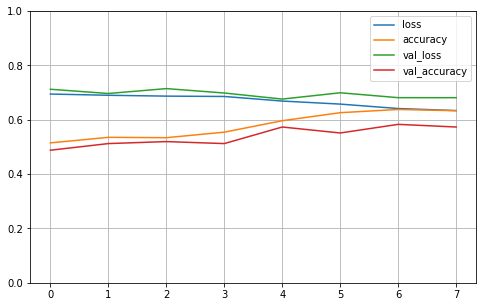


2023-03-26 18:30:20.981059

Testing # 1 2
2023-03-26 18:30:20.981148
2023-03-26 18:30:20.981178
PREDICT
2023-03-26 18:30:21.084142
Test 1:0 189:221 46.10%
Predict 1:0 194:216 47.32%
Test sizes (410, 4997) (410,)
Range of scores: 0.075089246 to 0.87265515
Score threshold 0.5
Confusion matrix
 [[131  90]
 [ 85 104]]
Normalized matrix
 [[0.3195122  0.2195122 ]
 [0.20731707 0.25365854]]


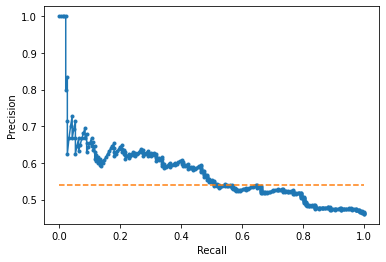

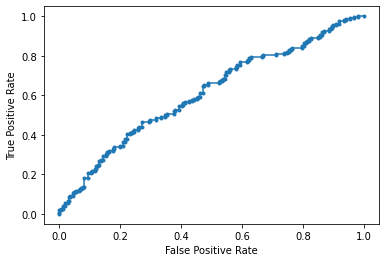

Accuracy: 57.32% Precision: 53.61% Recall: 55.03%
F1: 54.31% MCC: 0.1428
AUPRC: 57.23% AUROC: 61.14%
 accuracy [57.3170731707317]
 precision [53.608247422680414]
 recall [55.026455026455025]
 F1 [54.308093994778076]
 MCC [0.14279415762748737]
 AUPRC [57.226952567064295]
 AUROC [61.13624937154349]
2023-03-26 18:30:21.652093

Training # 1 3
2023-03-26 18:30:21.652251
2023-03-26 18:30:21.652294
Discriminator ZERO -1
Train 1:0 766:792 49.17%
Computed class weights: {0: 0.9835858585858586, 1: 1.016971279373368}
Valid 1:0 172:201 46.11%
FIT
2023-03-26 18:30:22.232698


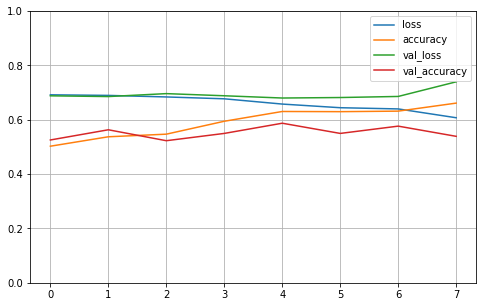


2023-03-26 18:30:34.074040

Testing # 1 3
2023-03-26 18:30:34.074144
2023-03-26 18:30:34.074179
PREDICT
2023-03-26 18:30:34.164134
Test 1:0 172:201 46.11%
Predict 1:0 256:117 68.63%
Test sizes (373, 4997) (373,)
Range of scores: 0.06650868 to 0.9594463
Score threshold 0.5
Confusion matrix
 [[ 73 128]
 [ 44 128]]
Normalized matrix
 [[0.19571046 0.34316354]
 [0.11796247 0.34316354]]


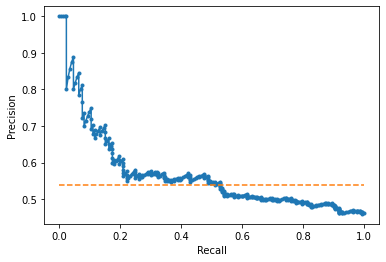

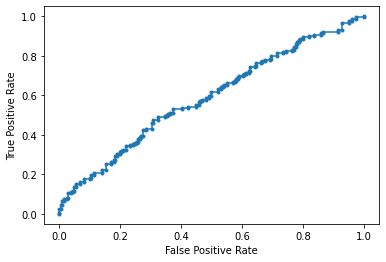

Accuracy: 53.89% Precision: 50.00% Recall: 74.42%
F1: 59.81% MCC: 0.1154
AUPRC: 56.71% AUROC: 58.92%
 accuracy [53.88739946380697]
 precision [50.0]
 recall [74.4186046511628]
 F1 [59.813084112149525]
 MCC [0.11535403803510276]
 AUPRC [56.71148305704672]
 AUROC [58.9234062246905]
2023-03-26 18:30:34.690474

Training # 1 4
2023-03-26 18:30:34.690608
2023-03-26 18:30:34.690648
Discriminator ZERO -1
Train 1:0 743:798 48.22%
Computed class weights: {0: 0.9655388471177945, 1: 1.0370121130551817}
Valid 1:0 195:195 50.00%
FIT
2023-03-26 18:30:35.266631


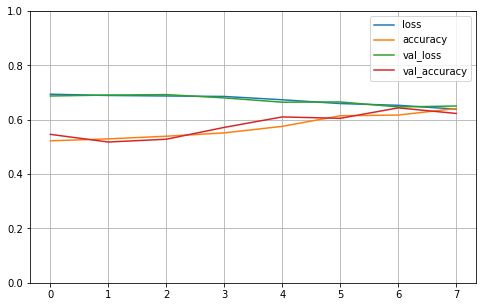


2023-03-26 18:30:46.649792

Testing # 1 4
2023-03-26 18:30:46.649882
2023-03-26 18:30:46.649916
PREDICT
2023-03-26 18:30:46.744084
Test 1:0 195:195 50.00%
Predict 1:0 220:170 56.41%
Test sizes (390, 4997) (390,)
Range of scores: 0.12142807 to 0.8826685
Score threshold 0.5
Confusion matrix
 [[109  86]
 [ 61 134]]
Normalized matrix
 [[0.27948718 0.22051282]
 [0.15641026 0.34358974]]


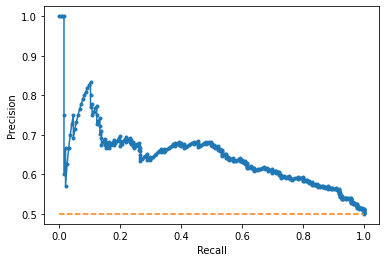

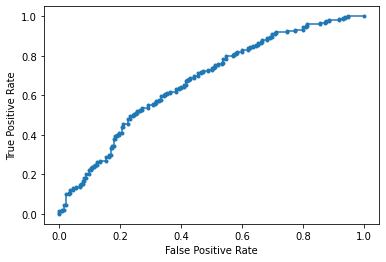

Accuracy: 62.31% Precision: 60.91% Recall: 68.72%
F1: 64.58% MCC: 0.2482
AUPRC: 64.63% AUROC: 67.32%
 accuracy [62.30769230769231]
 precision [60.909090909090914]
 recall [68.71794871794872]
 F1 [64.57831325301206]
 MCC [0.2482020911976092]
 AUPRC [64.63298648952319]
 AUROC [67.31623931623932]
2023-03-26 18:30:47.353349

Training # 1 5
2023-03-26 18:30:47.353481
2023-03-26 18:30:47.353522
Discriminator ZERO -1
Train 1:0 741:789 48.43%
Computed class weights: {0: 0.9695817490494296, 1: 1.0323886639676114}
Valid 1:0 197:204 49.13%
FIT
2023-03-26 18:30:47.934512


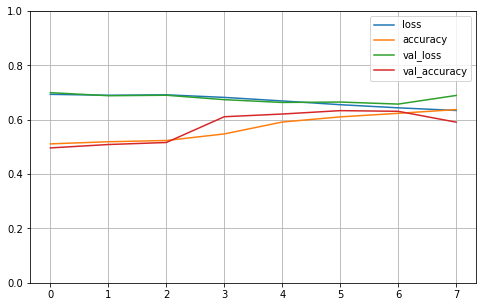


2023-03-26 18:30:59.298195

Testing # 1 5
2023-03-26 18:30:59.298298
2023-03-26 18:30:59.298333
PREDICT
2023-03-26 18:30:59.396138
Test 1:0 197:204 49.13%
Predict 1:0 287:114 71.57%
Test sizes (401, 4997) (401,)
Range of scores: 0.062858246 to 0.9409554
Score threshold 0.5
Confusion matrix
 [[ 77 127]
 [ 37 160]]
Normalized matrix
 [[0.19201995 0.31670823]
 [0.09226933 0.39900249]]


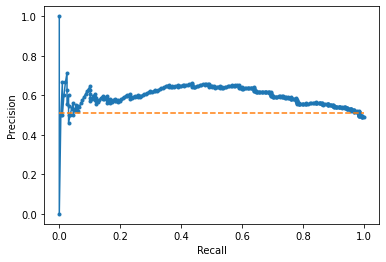

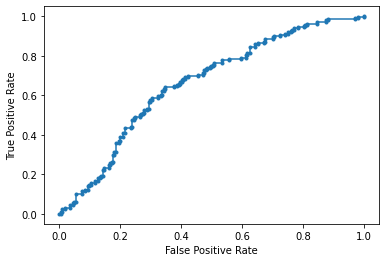

Accuracy: 59.10% Precision: 55.75% Recall: 81.22%
F1: 66.12% MCC: 0.2102
AUPRC: 59.55% AUROC: 65.97%
 accuracy [59.10224438902743]
 precision [55.749128919860624]
 recall [81.21827411167513]
 F1 [66.11570247933884]
 MCC [0.21016983864010516]
 AUPRC [59.54855605969359]
 AUROC [65.97242958096943]
2023-03-26 18:30:59.933665

Training # 2 1
2023-03-26 18:30:59.934459
2023-03-26 18:30:59.934505
Discriminator ZERO -1
Train 1:0 748:806 48.13%
Computed class weights: {0: 0.9640198511166254, 1: 1.0387700534759359}
Valid 1:0 190:187 50.40%
FIT
2023-03-26 18:31:00.503523


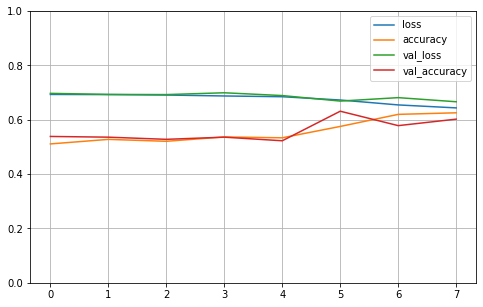


2023-03-26 18:31:08.047415

Testing # 2 1
2023-03-26 18:31:08.049999
2023-03-26 18:31:08.050352
PREDICT
2023-03-26 18:31:08.223011
Test 1:0 190:187 50.40%
Predict 1:0 142:235 37.67%
Test sizes (377, 4997) (377,)
Range of scores: 0.08282742 to 0.79964584
Score threshold 0.5
Confusion matrix
 [[136  51]
 [ 99  91]]
Normalized matrix
 [[0.36074271 0.13527851]
 [0.26259947 0.24137931]]


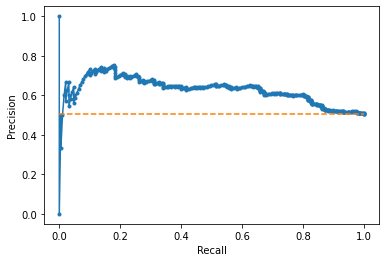

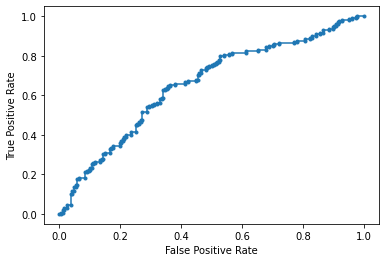

Accuracy: 60.21% Precision: 64.08% Recall: 47.89%
F1: 54.82% MCC: 0.2128
AUPRC: 62.61% AUROC: 65.49%
 accuracy [60.212201591511935]
 precision [64.08450704225352]
 recall [47.89473684210526]
 F1 [54.81927710843374]
 MCC [0.2127896422747226]
 AUPRC [62.61099073279082]
 AUROC [65.49113425274416]
2023-03-26 18:31:09.049517

Training # 2 2
2023-03-26 18:31:09.051072
2023-03-26 18:31:09.051398
Discriminator ZERO -1
Train 1:0 757:798 48.68%
Computed class weights: {0: 0.9743107769423559, 1: 1.0270805812417436}
Valid 1:0 181:195 48.14%
FIT
2023-03-26 18:31:09.681843


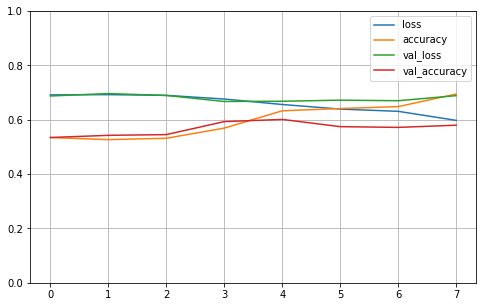


2023-03-26 18:31:16.827882

Testing # 2 2
2023-03-26 18:31:16.827984
2023-03-26 18:31:16.828018
PREDICT
2023-03-26 18:31:16.918359
Test 1:0 181:195 48.14%
Predict 1:0 239:137 63.56%
Test sizes (376, 4997) (376,)
Range of scores: 0.04328437 to 0.9420096
Score threshold 0.5
Confusion matrix
 [[ 87 108]
 [ 50 131]]
Normalized matrix
 [[0.23138298 0.28723404]
 [0.13297872 0.34840426]]


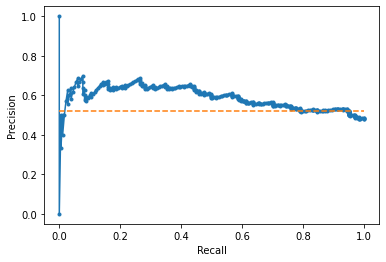

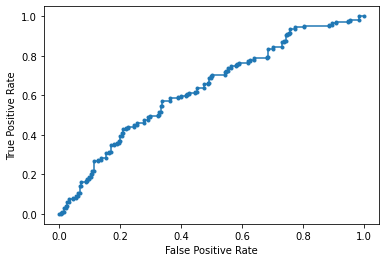

Accuracy: 57.98% Precision: 54.81% Recall: 72.38%
F1: 62.38% MCC: 0.1764
AUPRC: 58.70% AUROC: 63.59%
 accuracy [57.97872340425532]
 precision [54.811715481171554]
 recall [72.37569060773481]
 F1 [62.380952380952394]
 MCC [0.17640797783217976]
 AUPRC [58.695539838472286]
 AUROC [63.58691032724182]
2023-03-26 18:31:17.810654

Training # 2 3
2023-03-26 18:31:17.811558
2023-03-26 18:31:17.811607
Discriminator ZERO -1
Train 1:0 738:787 48.39%
Computed class weights: {0: 0.968869123252859, 1: 1.0331978319783197}
Valid 1:0 200:206 49.26%
FIT
2023-03-26 18:31:18.413777


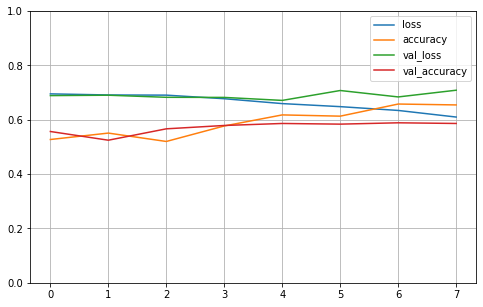


2023-03-26 18:31:29.993388

Testing # 2 3
2023-03-26 18:31:29.993488
2023-03-26 18:31:29.993521
PREDICT
2023-03-26 18:31:30.093873
Test 1:0 200:206 49.26%
Predict 1:0 244:162 60.10%
Test sizes (406, 4997) (406,)
Range of scores: 0.08225418 to 0.89567816
Score threshold 0.5
Confusion matrix
 [[100 106]
 [ 62 138]]
Normalized matrix
 [[0.24630542 0.26108374]
 [0.15270936 0.33990148]]


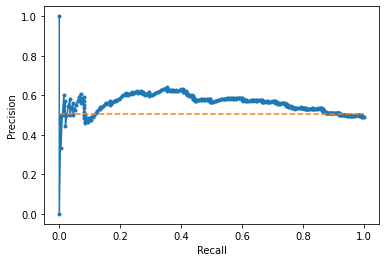

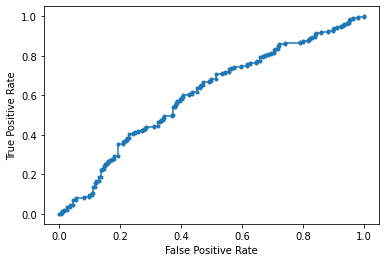

Accuracy: 58.62% Precision: 56.56% Recall: 69.00%
F1: 62.16% MCC: 0.1791
AUPRC: 56.03% AUROC: 60.45%
 accuracy [58.620689655172406]
 precision [56.557377049180324]
 recall [69.0]
 F1 [62.16216216216215]
 MCC [0.17910887886902885]
 AUPRC [56.034720285421166]
 AUROC [60.449029126213595]
2023-03-26 18:31:30.721152

Training # 2 4
2023-03-26 18:31:30.721845
2023-03-26 18:31:30.721907
Discriminator ZERO -1
Train 1:0 760:792 48.97%
Computed class weights: {0: 0.9797979797979798, 1: 1.0210526315789474}
Valid 1:0 178:201 46.97%
FIT
2023-03-26 18:31:31.318549


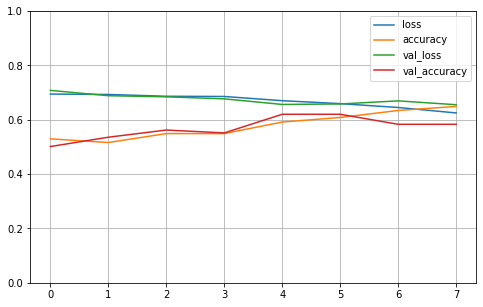


2023-03-26 18:31:42.703572

Testing # 2 4
2023-03-26 18:31:42.703667
2023-03-26 18:31:42.703705
PREDICT
2023-03-26 18:31:42.797619
Test 1:0 178:201 46.97%
Predict 1:0 166:213 43.80%
Test sizes (379, 4997) (379,)
Range of scores: 0.07491679 to 0.8459704
Score threshold 0.5
Confusion matrix
 [[128  73]
 [ 85  93]]
Normalized matrix
 [[0.33773087 0.19261214]
 [0.22427441 0.24538259]]


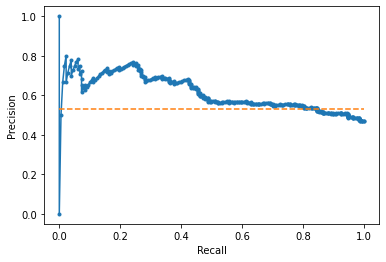

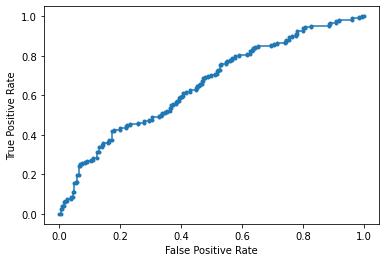

Accuracy: 58.31% Precision: 56.02% Recall: 52.25%
F1: 54.07% MCC: 0.1602
AUPRC: 61.17% AUROC: 65.41%
 accuracy [58.31134564643799]
 precision [56.024096385542165]
 recall [52.24719101123596]
 F1 [54.06976744186047]
 MCC [0.16023108789950394]
 AUPRC [61.1680373250766]
 AUROC [65.40891050366146]
2023-03-26 18:31:43.334371

Training # 2 5
2023-03-26 18:31:43.334519
2023-03-26 18:31:43.334560
Discriminator ZERO -1
Train 1:0 749:789 48.70%
Computed class weights: {0: 0.9746514575411914, 1: 1.026702269692924}
Valid 1:0 189:204 48.09%
FIT
2023-03-26 18:31:43.914159


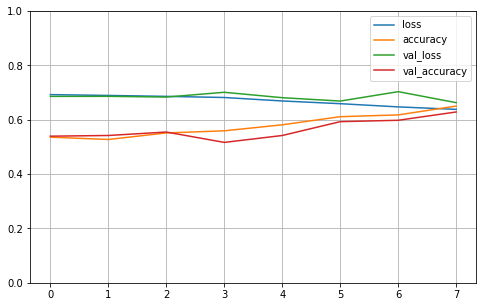


2023-03-26 18:31:52.204774

Testing # 2 5
2023-03-26 18:31:52.204876
2023-03-26 18:31:52.204911
PREDICT
2023-03-26 18:31:52.317266
Test 1:0 189:204 48.09%
Predict 1:0 191:202 48.60%
Test sizes (393, 4997) (393,)
Range of scores: 0.1470088 to 0.91098493
Score threshold 0.5
Confusion matrix
 [[130  74]
 [ 72 117]]
Normalized matrix
 [[0.3307888  0.18829517]
 [0.18320611 0.29770992]]


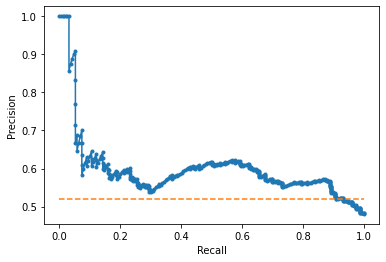

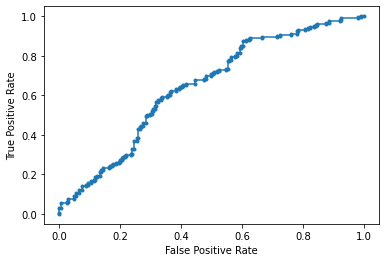

Accuracy: 62.85% Precision: 61.26% Recall: 61.90%
F1: 61.58% MCC: 0.2562
AUPRC: 59.93% AUROC: 64.51%
 accuracy [62.849872773536894]
 precision [61.25654450261781]
 recall [61.904761904761905]
 F1 [61.578947368421055]
 MCC [0.25621614668097464]
 AUPRC [59.9271897151864]
 AUROC [64.5113600995954]
2023-03-26 18:31:52.837198


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.69% std 2.67
 precision mean 57.79% std 4.81
 recall mean 61.69% std 14.33
 F1 mean 58.45% std 6.47
 MCC mean 0.19% std 0.05
 AUPRC mean 59.69% std 2.69
 AUROC mean 63.47% std 2.74
 accuracy [[56.30252100840336], [57.3170731707317], [53.88739946380697], [62.30769230769231], [59.10224438902743], [60.212201591511935], [57.97872340425532], [58.620689655172406], [58.31134564643799], [62.849872773536894]]
 precision [[64.94845360824742], [53.608247422680414], [50.0], [60.909090909090914], [55.749128919860624], [64.08450704225352], [54.811715481171554], [56.557377049180324], [56.024096385542165], [61.25654450261781]]
 recall [[34.054054054054056], [55.026455026455025], [74.4186046511628], [68.71794871794872], [81.21827411167513], [47.89473684210526], [72.37569060773481], [69.0], [52.24719101123596], [61.904761904761905]]
 F1 [[44.68085106382979], [54.308093994778076], [59.813084112149525], [64.57831325301206], [66.11570247933884], [54.81927710843374], [62.380952380952394], 